In [2]:
import sys, os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# Use below for charts in dark jupyter theme

THEME_DARK = False

if THEME_DARK:
    # This is used if Jupyter Theme dark is enabled. 
    # The theme chosen can be activated with jupyter theme as follows:
    # >>> jt -t oceans16 -T -nfs 115 -cellw 98% -N  -kl -ofs 11 -altmd
    font_size = '20.0'
    dark_theme_config = {
        "ytick.color" : "w",
        "xtick.color" : "w",
        "text.color": "white",
        'font.size': font_size,
        'axes.titlesize': font_size,
        'axes.labelsize': font_size, 
        'xtick.labelsize': font_size, 
        'ytick.labelsize': font_size, 
        'legend.fontsize': font_size, 
        'figure.titlesize': font_size,
        'figure.figsize': [20, 7],
        'figure.facecolor': "#384151",
        'legend.facecolor': "#384151",
        "axes.labelcolor" : "w",
        "axes.edgecolor" : "w"
    }
    plt.rcParams.update(dark_theme_config)

sys.path.append("..")

import xai
import xai.data

In [3]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "loan"]

In [14]:
df = xai.data.load_census()
df.tail()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,loan
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K
32560,52,Self-emp-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,>50K


In [5]:
target = "loan"
protected = ["ethnicity", "gender", "age"]

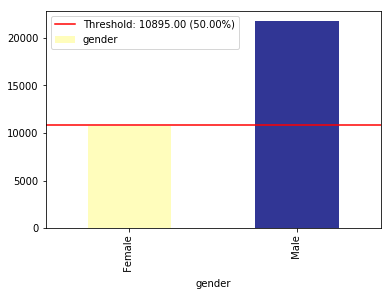

In [24]:
df_groups = xai.imbalance_plot(df, "gender", categorical_cols=categorical_cols)

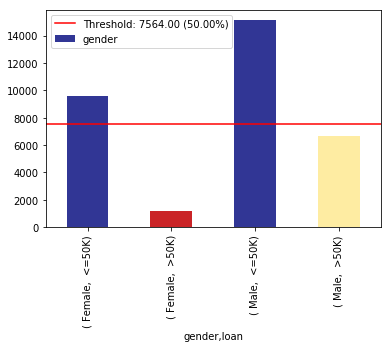

In [23]:
groups = xai.imbalance_plot(df, "gender", "loan", categorical_cols=categorical_cols)

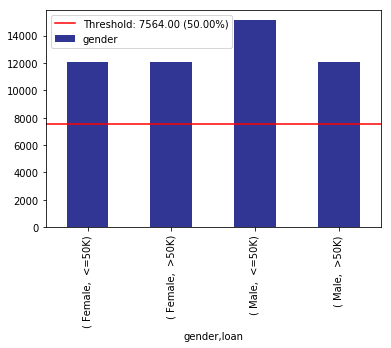

In [22]:
bal_df = xai.balance(df, "gender", "loan", upsample=0.8, categorical_cols=categorical_cols)

In [20]:
groups = xai.group_by_columns(df, ["gender", "loan"], categorical_cols=categorical_cols)
for group, group_df in groups:
    print(group)
    print(group_df["loan"].head(), "\n")

(' Female', ' <=50K')
4      <=50K
5      <=50K
6      <=50K
12     <=50K
21     <=50K
Name: loan, dtype: object 

(' Female', ' >50K')
8      >50K
19     >50K
52     >50K
67     >50K
84     >50K
Name: loan, dtype: object 

(' Male', ' <=50K')
0      <=50K
1      <=50K
2      <=50K
3      <=50K
13     <=50K
Name: loan, dtype: object 

(' Male', ' >50K')
7      >50K
9      >50K
10     >50K
11     >50K
14     >50K
Name: loan, dtype: object 



/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


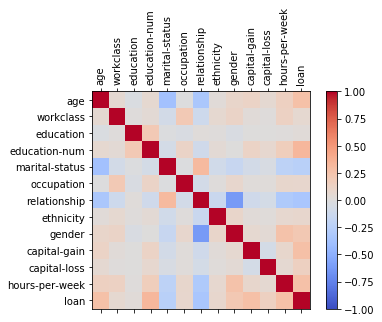

In [25]:
_ = xai.correlations(df, include_categorical=True, plot_type="matrix")

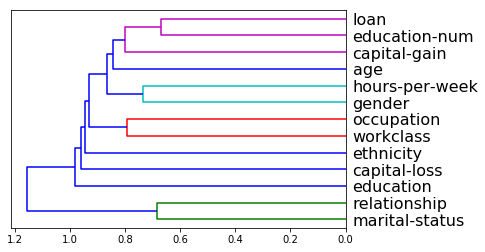

In [26]:
_ = xai.correlations(df, include_categorical=True)

Total number of examples:  1200


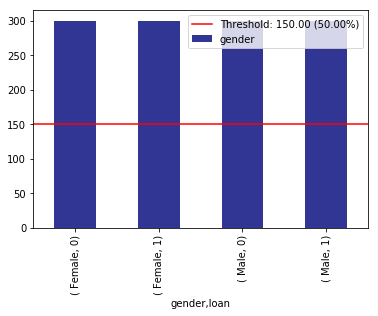

In [40]:
proc_df = xai.normalize_numeric(bal_df)
proc_df = xai.convert_categories(proc_df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test, train_idx, test_idx = \
    xai.balanced_train_test_split(
            x, y, "gender", 
            min_per_group=300,
            max_per_group=300,
            categorical_cols=categorical_cols)

x_train_display = bal_df[train_idx]
x_test_display = bal_df[test_idx]

print("Total number of examples: ", x_test.shape[0])

df_test = x_test_display.copy()
df_test["loan"] = y_test

_= xai.imbalance_plot(df_test, "gender", "loan", categorical_cols=categorical_cols)

In [41]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs, threshold=0.5):
    """Convert probabilities into classes"""
    return list((probs >= threshold).astype(int).T[0])


In [42]:
model = build_model(x_train)

model.fit(f_in(x_train), y_train, epochs=50, batch_size=512)

Epoch 1/50
50234/50234 [==============================] - 2s 31us/step - loss: 0.5588 - acc: 0.7166
Epoch 2/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.4304 - acc: 0.7980
Epoch 3/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3880 - acc: 0.8199
Epoch 4/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3778 - acc: 0.8243
Epoch 5/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3739 - acc: 0.8264
Epoch 6/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3705 - acc: 0.8283
Epoch 7/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3689 - acc: 0.8299
Epoch 8/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3681 - acc: 0.8308
Epoch 9/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3687 - acc: 0.8306
Epoch 10/50
50234/50234 [==============================] - 0s 7us/step - loss: 0.3661 - acc: 0.8325
Epoch 11

In [43]:
score = model.evaluate(f_in(x_test), y_test, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1200/1200 [==============================] - 0s 231us/step
Error 0.3455: 
Accuracy 83.7500: 


In [44]:
probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

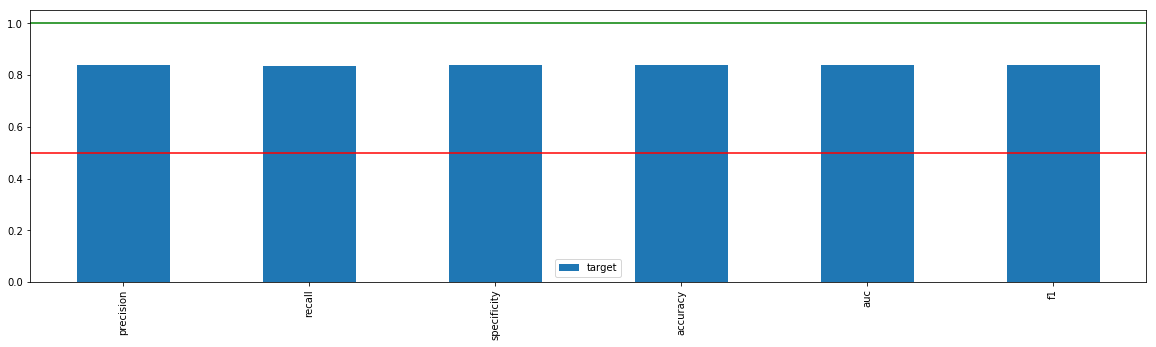

In [45]:
_= xai.metrics_plot(
        y_test, 
        probabilities)

In [55]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K


(8, 15)
(16, 15)
(66, 15)
(4, 15)
(506, 15)
(3, 15)
(19, 15)
(39, 15)
(2, 15)
(537, 15)


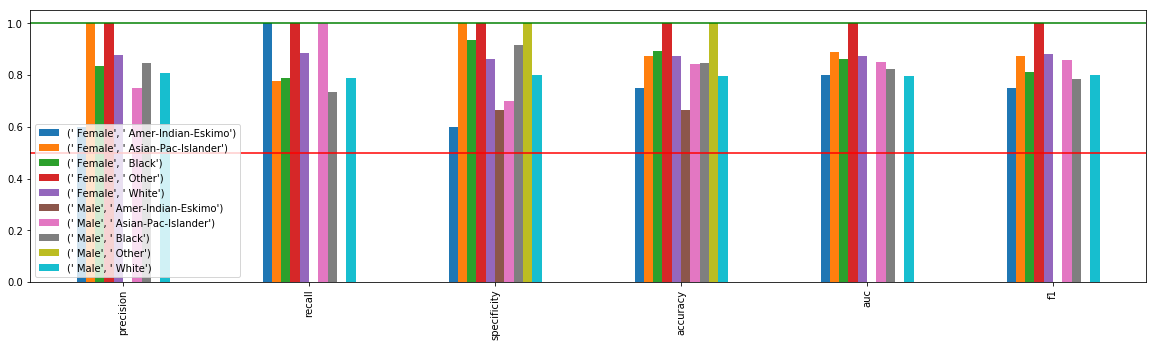

In [59]:
_ = xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=["gender", "ethnicity"],
    categorical_cols=categorical_cols)

       'relationship', 'ethnicity', 'gender', 'loan', 'target'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]
       'relationship', 'ethnicity', 'gender', 'loan', 'target'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]
       'relationship', 'ethnicity', 'gender', 'loan', 'target'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]


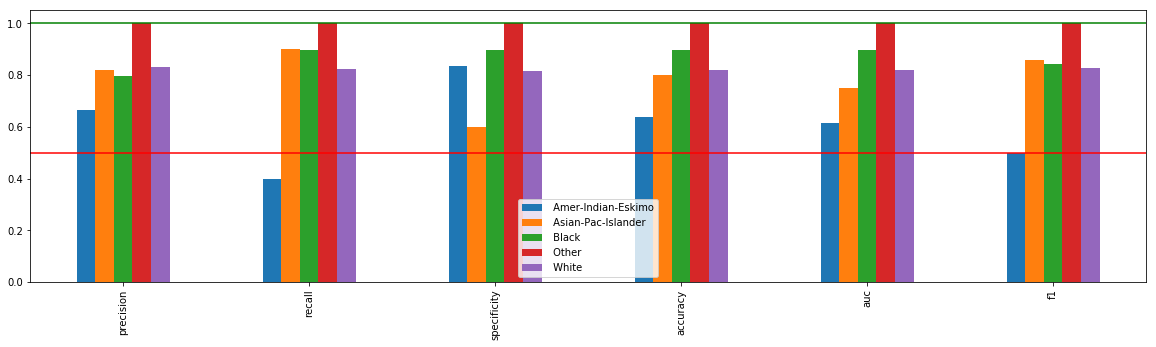

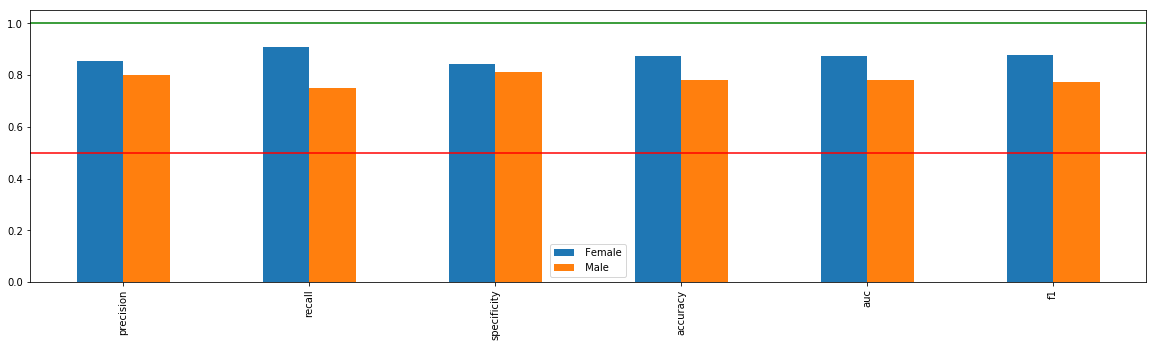

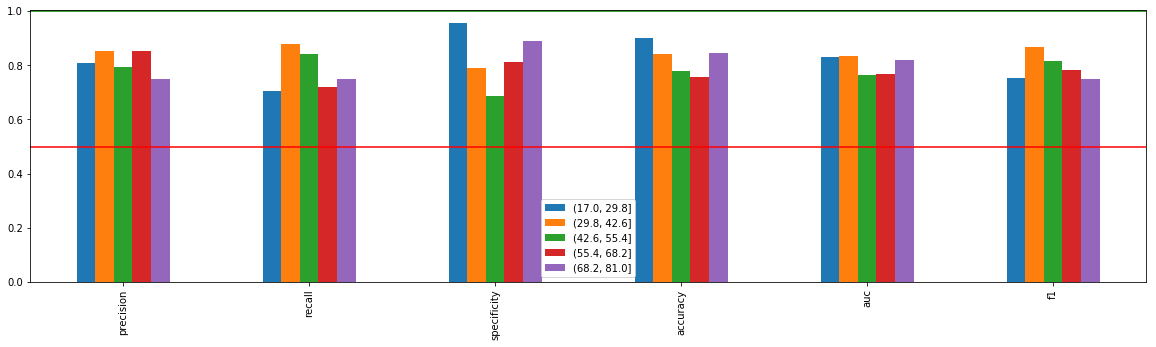

In [37]:
_ = [xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=[p],
    categorical_cols=categorical_cols) for p in protected]

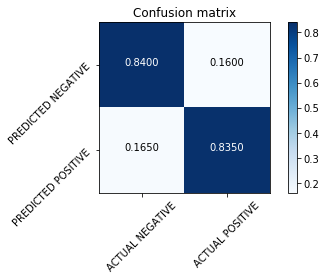

In [60]:
xai.confusion_matrix_plot(y_test, pred)

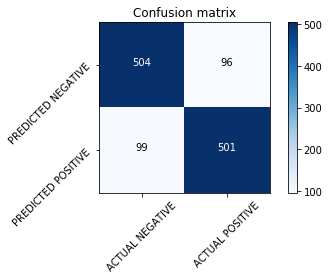

In [61]:
xai.confusion_matrix_plot(y_test, pred, scaled=False)

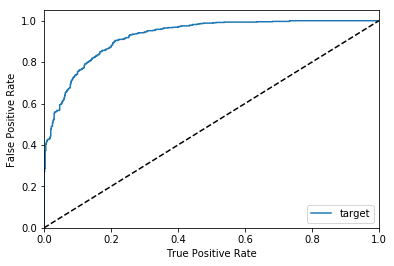

In [62]:
_ = xai.roc_plot(y_test, probabilities)

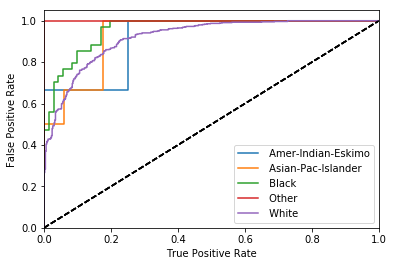

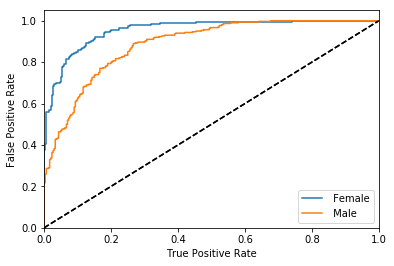

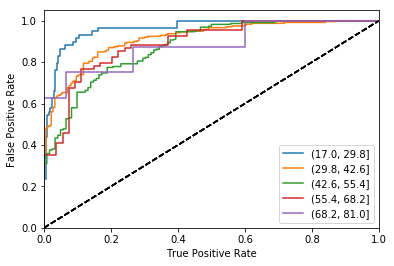

In [66]:
_ = [xai.roc_plot(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=[p],
    categorical_cols=categorical_cols) for p in protected]

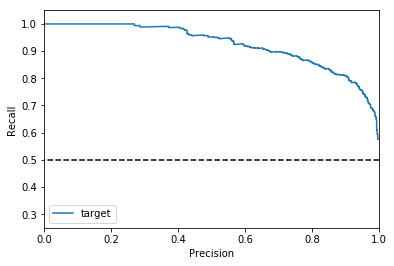

In [67]:
_= xai.pr_plot(y_test, probabilities)

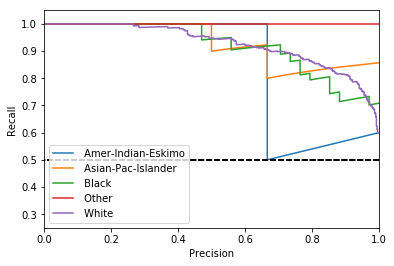

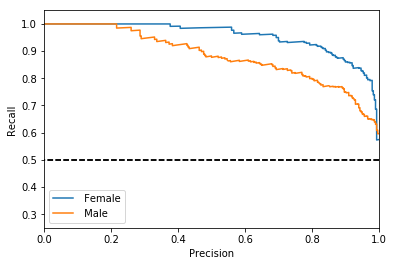

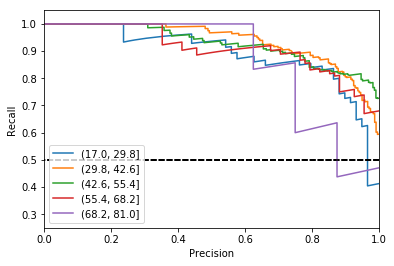

In [68]:
_ = [xai.pr_plot(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=[p],
    categorical_cols=categorical_cols) for p in protected]

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


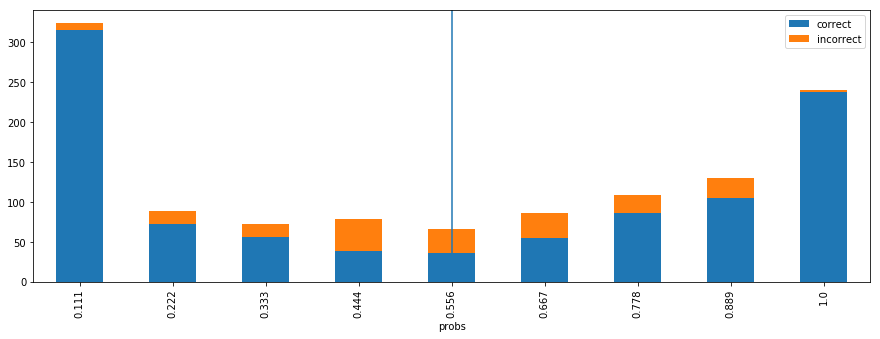

In [69]:
d = xai.smile_imbalance(
    y_test, 
    probabilities)

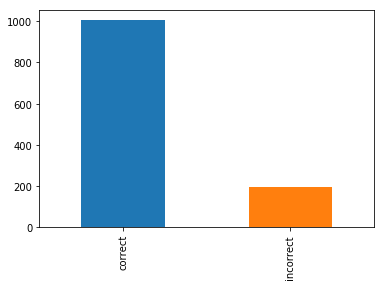

In [70]:
d[["correct", "incorrect"]].sum().plot.bar()

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


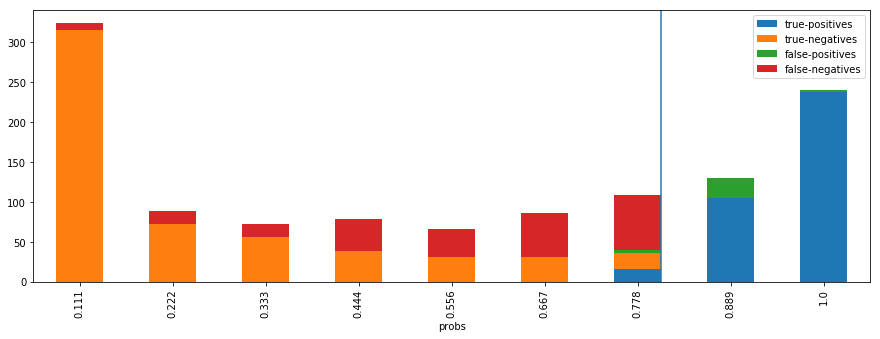

In [71]:
d = xai.smile_imbalance(
    y_test, 
    probabilities,
    threshold=0.75,
    display_breakdown=True)

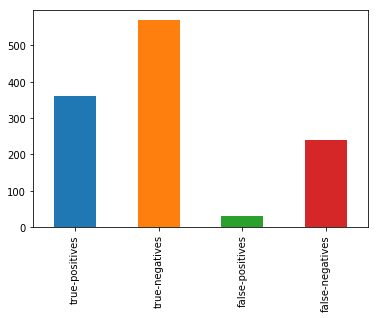

In [72]:
display_bars = ["true-positives", "true-negatives", 
                "false-positives", "false-negatives"]
d[display_bars].sum().plot.bar()

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


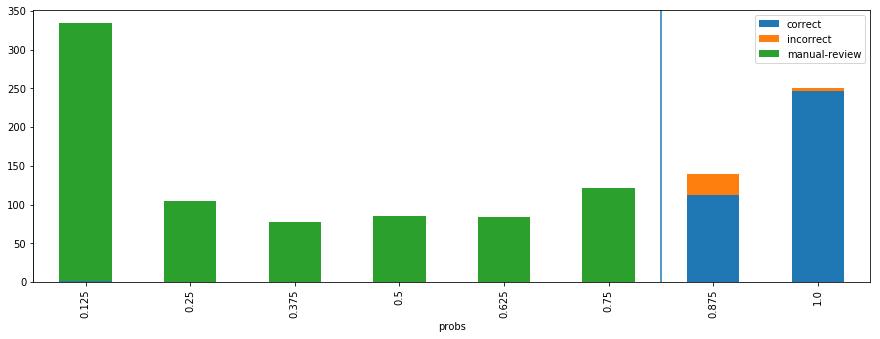

In [73]:
d = xai.smile_imbalance(
    y_test, 
    probabilities,
    bins=9,
    threshold=0.75,
    manual_review=0.00001,
    display_breakdown=False)

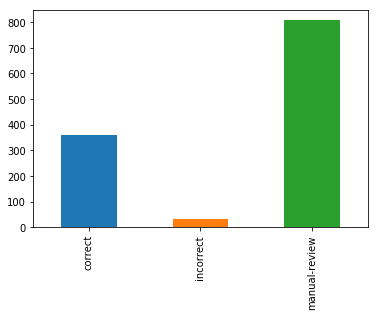

In [74]:
d[["correct", "incorrect", "manual-review"]].sum().plot.bar()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week
0,0.030583,0.0045,-0.000417,0.044083,0.089583,0.018417,0.02575,0.002417,0.001167,0.040667,0.003083,0.011917


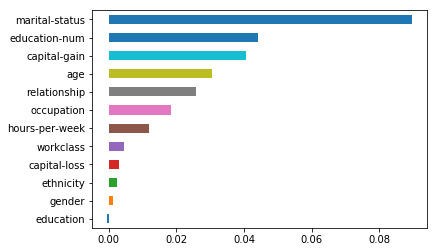

In [75]:
def get_avg(x, y):
    return model.evaluate(f_in(x), y, verbose=0)[1]

imp = xai.feature_importance(x_test, y_test, get_avg)

imp.head()